# Random polymer loop
This example shows you how to run a simple polymer simulation in hoomdd.

Here is a script that generates a system of bead-spring polymers that self-assemble into a hex phase when run for a few million time steps. The polymers are A6B7A6 block copolymers in an implicit solvent. The script also shows a few examples of how writing python code in the script can be handy: here the concentration phi_P is a parameter and math operations are performed to calculate the length of the box.

For more information on the model in this script, see
"Micellar crystals in solution from molecular dynamics simulations"
J. Chem. Phys. 128, 184906 (2008); DOI:10.1063/1.2913522
http://link.aip.org/link/?JCPSA6/128/184906/1

Any of the polymer systems in the paper could be easily run just by changing a few parameters in this script.
from: https://lost-contact.mit.edu/afs//umich.edu/user/j/o/joaander/Public/hoomd-web/doc/page_example_scripts.html

## Initialize
First import hoomd and associated libraries and then initialize.  If no mode is given then the fastest processor cpu or gpu will be selected automatically.

In [1]:
import hoomd
from hoomd import *
from hoomd import md
from hoomd import deprecated
#hoomd.context.initialize();
hoomd.context.initialize("--mode=cpu");
#hoomd.context.initialize("--mode=gpu");

HOOMD-blue v2.2.2-29-g1e86eec CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 
Compiled: 01/29/18
Copyright 2009-2017 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


## Import other libraries and define parameters

In [2]:
#import math
import math
# parameters (polymer physics)
phi_P = 0.25 # this has to do with how good of a solvent the polymer is in and is only used to calculate the box size below
n_poly = 1 # n_poly in the number of polymers in the simulation
n_beads = 18

## Define the polymer and simulation parameters

In [3]:
# This polymer can be made up of two different types A and B.  It's called a block copolymer.
polymer1 = dict(bond_len=1.2, type=['B']*1 + ['A']*n_beads + ['B']*1,bond="linear", count=n_poly)
# perform some simple math to find the length of the box
N = len(polymer1['type']) * polymer1['count']
# generate the polymer system
V=1000*math.pi * N / (6.0 * phi_P)
L=round(V**(1.0/3.0))

# define simulation parameters
epsilon=100
period=100
N=1e7

system=deprecated.init.create_random_polymers(\
                                              box=data.boxdim(L=L), \
                                              polymers=[polymer1],\
                                              separation=dict(A=0.35, B=0.35)\
                                              ,seed=12)

notice(2): Group "all" created containing 20 particles


## Setup the bonds and force fields

In [4]:
# force field setup
harmonic = md.bond.harmonic()
harmonic.bond_coeff.set('polymer', k=330.0, r0=0.84)
nl = md.nlist.cell();
lj = md.pair.lj(r_cut=3.0,nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0, alpha=0.0)
lj.pair_coeff.set('A', 'B', epsilon=1.0, sigma=1.0, alpha=0.0)
lj.pair_coeff.set('B', 'B', epsilon=epsilon, sigma=1.0, alpha=1.0)

## Integrate the simulation

In [5]:
import numpy
import math
# integrate NVT for a bunch of time steps
all = group.all()
md.integrate.mode_standard(dt=0.005)
md.integrate.nvt(group=all, kT=1.2, tau=0.5)



gsd_filename="gsd/random_polymer_loop_%2.0f.gsd" % epsilon
log_filename="ree_%2.0f.log" % epsilon

#save a gsd polymer configuration every 100 timesteps
dump.gsd(gsd_filename, period=100, group=all, overwrite=True);

#log position of particle 0
polymers=['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10']
log = hoomd.analyze.log(filename=log_filename,
                         quantities=polymers[0:n_poly],
                         period=period,
                         overwrite=True);

for i in range(n_poly):
    print(polymers[i],(n_beads+2)*i,(n_beads+2)*i+n_beads+1)
    log.register_callback(polymers[i], lambda timestep,i=i: math.sqrt( \
    # ((system.particles[(n_beads+2)*i].position[0]-system.particles[(n_beads+2)*i+n_beads+1].position[0])%L)**2\
    #+((system.particles[(n_beads+2)*i].position[1]-system.particles[(n_beads+2)*i+n_beads+1].position[1])%L)**2\
    #+((system.particles[(n_beads+2)*i].position[2]-system.particles[(n_beads+2)*i+n_beads+1].position[2])%L)**2));
     (system.particles[(n_beads+2)*i].position[0]-system.particles[(n_beads+2)*i+n_beads+1].position[0])**2\
    +(system.particles[(n_beads+2)*i].position[1]-system.particles[(n_beads+2)*i+n_beads+1].position[1])**2\
    +(system.particles[(n_beads+2)*i].position[2]-system.particles[(n_beads+2)*i+n_beads+1].position[2])**2));

#run(2000)

#hoomd.dump.gsd(filename="gsd/random_polymer_loop_0.gsd", overwrite=True, period=None, group=group.all(), time_step=0)
# setup the IMD server
#hoomd.analyze.imd(port=54321, period=10)
# run a very long time so the simulation can be watched in VMD
run(N)

#vmd -e imd2.vmd gsd/create_random_polymer_loop_0.gsd
#!cat imd2.vmd

('p1', 0, 19)
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 1 exclusions             : 2
notice(2): Particles with 2 exclusions             : 18
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 2352799 / 10000000 | TPS 235280 | ETA 00:00:32
Time 00:00:20 | Step 4755288 / 10000000 | TPS 240249 | ETA 00:00:21
Time 00:00:30 | Step 7146743 / 10000000 | TPS 239145 | ETA 00:00:11
Time 00:00:40 | Step 9432202 / 10000000 | TPS 228546 | ETA 00:00:02
Time 00:00:42 | Step 10000000 / 10000000 | TPS 223480 | ETA 00:00:00
Average TPS: 235058
---------
-- Neighborlist stats:
656147 normal updates / 100000 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 17 / n_neigh_avg: 5.8
shortest rebuild period: 5
-- Cell list stats:
Dimension: 10, 10, 10
n_min    : 0 / n_max: 10 / n_avg: 0.02
** run complete **


## Plot results and correlation function

(99800, 1)


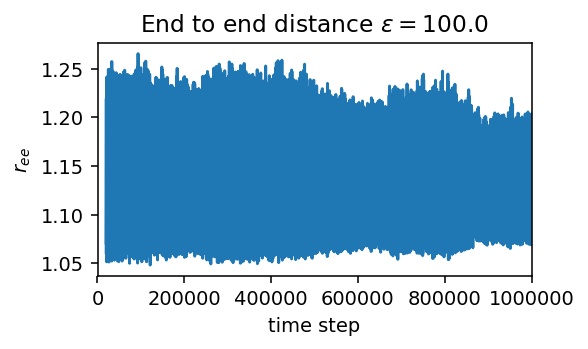

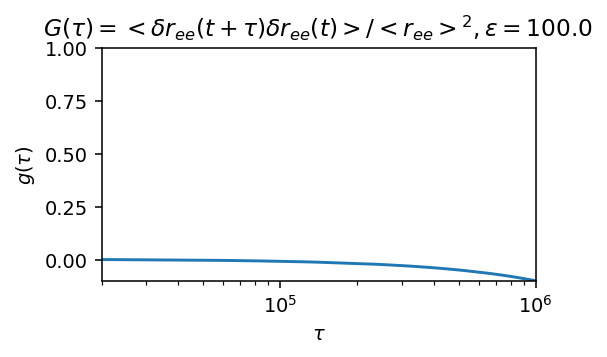

In [18]:
from matplotlib import pyplot
%matplotlib inline
#!head log_filename
cut=20000
data = numpy.genfromtxt(fname=log_filename,skip_header=True);
t=numpy.ndarray.flatten(data[cut/period:,0])
#r_ee=numpy.ndarray.flatten(data[1000:,1])
r_ee=data[cut/period:,1:]#/(101*(0.84**2))
print(numpy.shape(r_ee))
pyplot.figure(figsize=(4,2.2), dpi=140);
#pyplot.plot(t,r_ee);
for i in range(n_poly):
    #pyplot.figure(figsize=(4,2.2), dpi=140);
    pyplot.title(r'End to end distance $\epsilon=%3.1f$' % epsilon)
    pyplot.xlim(period,N/10)
    pyplot.plot(t,r_ee[:,i]%22);
    pyplot.xlabel(r'time step');
    pyplot.ylabel(r'$r_{ee}$');
#r_ee=r_ee[len(r_ee)/2:]
pyplot.savefig('r_ee_%2.0f.png' % epsilon)
def autocorr(x):
    result = numpy.correlate(x, x, mode='full')/(len(x)-1)/(numpy.average(x)**2)-1.0
    return result[result.size/2:]
pyplot.figure(figsize=(4,2.2), dpi=140);
for i in range(n_poly):
    #pyplot.figure(figsize=(4,2.2), dpi=140);
    pyplot.title(r'$G(\tau)=<\delta r_{ee}(t+\tau) \delta r_{ee}(t)>/<r_{ee}>^2, \epsilon=%3.1f$' % epsilon)
    pyplot.xlim(cut,N/10)
    pyplot.ylim(-.1,1)
    g=autocorr(numpy.ndarray.flatten(r_ee[:,i]))
    pyplot.semilogx(t[:len(g)],g)
    #pyplot.plot(t,g)
    pyplot.xlabel(r'$\tau$');
    pyplot.ylabel(r'$g(\tau)$');
pyplot.savefig('g_tau_%2.0f.png' % epsilon)

The results of this example may be visualized with VMD which can be installed from here: http://www.ks.uiuc.edu/Research/vmd/

In [13]:
!vmd -e vdw.vmd "%s" % gsd_filename
#import subprocess
#subprocess.call(["vmd"," -e"," vdw.vmd"," %s" % gsd_filename])

/usr/local/lib/vmd/vmd_LINUXAMD64: /usr/lib/nvidia-390/libGL.so.1: no version information available (required by /usr/local/lib/vmd/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.4a12 (December 21, 2017)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 4 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA 
Info) Free system memory: 12GB (74%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX 1060 6GB 10 SM_6.1 1.84 GHz, 5.9GB RAM, KTO, AE2, ZCP
Warning) Detected X11 'Composite' extension: if incorrect display occurs

[](snapshots/random_polymer_loop.png)

In [8]:
!echo $PATH

/home/mattferguson/miniconda2/bin:/home/mattferguson/miniconda2/bin:/usr/local/cuda-8.0/bin:/home/mattferguson/bin:/home/mattferguson/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:NVIDIA_CUDA-8.0_Samples/bin/x86_64/linux/release/


In [9]:
print len(t)

99800


In [10]:
print len(r)

NameError: name 'r' is not defined